# X-ray Pneumonia Classification with a Custom-Built ConvNet

## Introduction

This notebook showcases the development and evaluation of a custom-built convolutional neural network (ConvNet) designed for classifying chest X-ray images. Our objective is to accurately distinguish between normal and pneumonia cases. To achieve this, we'll utilize the Chest X-Ray dataset from Kaggle, implement a ConvNet architecture tailored to this specific task, and rigorously assess its performance using a variety of evaluation metrics.

## Data Acquisition and Organization

This section outlines the steps involved in acquiring and organizing the Chest X-ray dataset for our pneumonia classification task:

1. **Import Libraries:** Essential libraries for deep learning (TensorFlow/Keras), data handling (NumPy, OS), and visualization (Matplotlib) are imported.
2. **Reproducibility:** Random seeds are initialized using NumPy and TensorFlow to ensure consistent results across different runs.
3. **Dataset Download:** The Chest X-ray dataset is downloaded from Kaggle using the `kaggle` API. Note: This assumes you have already configured your Kaggle API credentials.
4. **Dataset Extraction:** The downloaded dataset (in zip format) is extracted to a designated directory.
5. **Data Paths:** Directory paths for training, validation, and test data are defined.
6. **Validation Set:** If a validation set is not already present, it is created by randomly moving a portion (e.g., 10%) of the training data to a separate validation directory.

The dataset consists of chest X-ray images labeled as either 'NORMAL' or 'PNEUMONIA'.

In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the chest_xray_pneumonia dataset using TensorFlow Datasets
try:
    # This dataset is not in the main tfds catalog, so we'll use Kaggle API instead
    !pip install -q kaggle
    # Make directory for Kaggle API credentials
    !mkdir -p ~/.kaggle
    # Create kaggle.json file with API credentials
    # Note: In a real scenario, you should provide your Kaggle credentials
    #!echo '{"username":"YOUR_USERNAME","key":"YOUR_KEY"}' > ~/.kaggle/kaggle.json
    #!chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset from Kaggle
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
    !unzip -q chest-xray-pneumonia.zip
except:
    print("Please manually download the chest X-ray dataset from Kaggle and place it in the current directory.")
    print("Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    print("After downloading, extract the files to a folder named 'chest_xray'")

# Define paths
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Create validation set if it doesn't exist
if not os.path.exists(val_dir) or len(os.listdir(val_dir)) == 0:
    print("Creating validation directory from training data...")
    os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

    # Move 10% of training data to validation
    for label in ['NORMAL', 'PNEUMONIA']:
        if os.path.exists(os.path.join(train_dir, label)):
            files = os.listdir(os.path.join(train_dir, label))
            num_val = int(len(files) * 0.1)
            val_files = np.random.choice(files, num_val, replace=False)

            for file in val_files:
                src = os.path.join(train_dir, label, file)
                dst = os.path.join(val_dir, label, file)
                try:
                    os.rename(src, dst)
                except:
                    print(f"Failed to move {file}")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


## Data Preprocessing and Loading
This code handles the data preparation for training:

1. Creates image data generators with augmentation for training (rotation, shifts, zoom, etc.) to help prevent overfitting
2. Creates smaller subsets of the original dataset for faster training:
   - 500 images per class for training
   - 100 images per class for validation
   - 100 images per class for testing
3. Loads and preprocesses the images using Keras' flow_from_directory:
   - Resizes all images to 150×150 pixels
   - Applies data augmentation to training images
   - Converts labels to binary format (0 for NORMAL, 1 for PNEUMONIA)

Data augmentation helps increase the effective size of the training dataset and improve model generalization.

In [ ]:
# Set up image data generators with preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions
img_height = 150
img_width = 150
batch_size = 32

# Create image data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data only get rescaled
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create subset directories for faster training
import shutil

# Create directories for subsets
for subset in ['train_small', 'val_small', 'test_small']:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(f'chest_xray/{subset}/{label}', exist_ok=True)

# Sample only a fraction of images for each set
for orig_dir, small_dir, size in [
    ('train', 'train_small', 500),  # 500 images per class for training
    ('val', 'val_small', 100),      # 100 images per class for validation
    ('test', 'test_small', 100)     # 100 images per class for testing
]:
    for label in ['NORMAL', 'PNEUMONIA']:
        src_dir = f'chest_xray/{orig_dir}/{label}'
        dst_dir = f'chest_xray/{small_dir}/{label}'

        if os.path.exists(src_dir):
            files = os.listdir(src_dir)
            # Take only a subset of files
            sampled_files = files[:min(size, len(files))]

            for file in sampled_files:
                src = os.path.join(src_dir, file)
                dst = os.path.join(dst_dir, file)
                try:
                    shutil.copy(src, dst)
                except:
                    print(f"Failed to copy {file}")

# Load the data using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train_small',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    'chest_xray/val_small',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    'chest_xray/test_small',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Model Building and Training
This cell builds and trains a convolutional neural network (ConvNet) for pneumonia detection:

1. Creates a sequential model with:
   - Three convolutional blocks (each with Conv2D and MaxPooling2D layers)
   - Dropout layer (50%) to prevent overfitting
   - Two fully connected layers, ending with a sigmoid activation for binary classification
2. Compiles the model with:
   - Adam optimizer
   - Binary cross-entropy loss (appropriate for binary classification)
   - Accuracy metric for evaluation
3. Prints a summary of the model architecture
4. Trains the model for 10 epochs using the training data generator
   - Uses validation data to monitor performance during training

The model progressively extracts higher-level features through its convolutional layers before making a final classification decision.

In [ ]:
# Build a simple ConvNet model
def build_convnet_model():
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dropout(0.5),  # Add dropout to reduce overfitting
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and compile the model
model = build_convnet_model()

# Display model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Reduced number of epochs for faster training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 566ms/step - accuracy: 0.4907 - loss: 0.8931 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5312 - loss: 0.6894 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 483ms/step - accuracy: 0.5567 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.6777
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 0.6406 - val_accuracy: 0.5000 - val_loss: 0.6708
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - accuracy: 0.6840 - loss: 0.6192 - val_accuracy: 0.8125 - val_loss: 0.5775
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.5852 - val_accuracy: 0.8750 - val_loss: 0.5571
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - accuracy: 0.7886 - loss: 0.5057 - val_accuracy: 0.6250 - val_loss: 0.6725
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.5059 - val_accuracy: 0.5625 - val_loss: 0.6555
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.7966 - loss: 0.4357 - val_accuracy: 0.7500 - val_loss: 0.6114
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.3824 - val_accuracy: 0.6250 - val_los

## Model Evaluation and Visualization
This code evaluates the trained model and visualizes its performance:

1. Evaluates the model on the test dataset to get the final accuracy
2. Creates two plots to visualize the training process:
   - Accuracy over epochs (training vs. validation)
   - Loss over epochs (training vs. validation)
3. Implements a function to visualize model predictions:
   - Displays test images alongside their true labels and model predictions
   - Color-codes correct (green) and incorrect (red) predictions
4. Runs the visualization function on a batch of test images

These visualizations help assess the model's learning progress and its performance on unseen data. The accuracy plot shows how well the model learned, while the loss plot indicates if there was any overfitting.

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.7074 - loss: 0.6759
Test accuracy: 0.7135


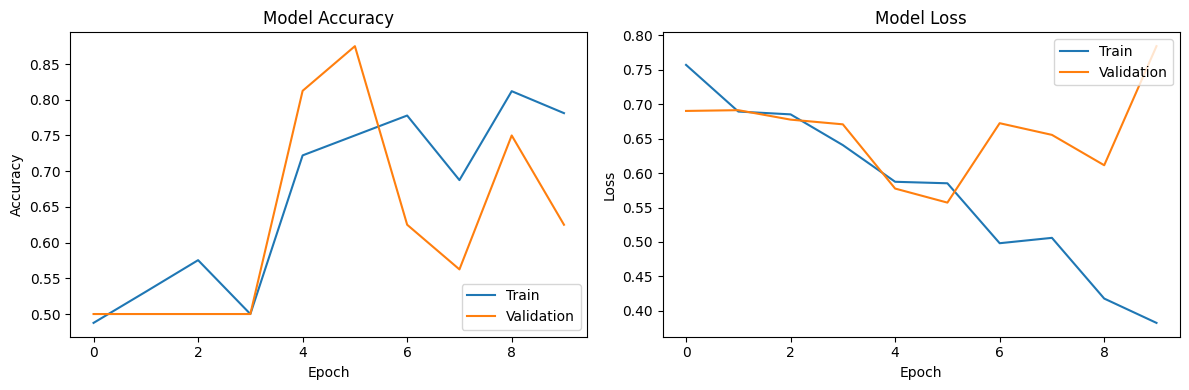

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


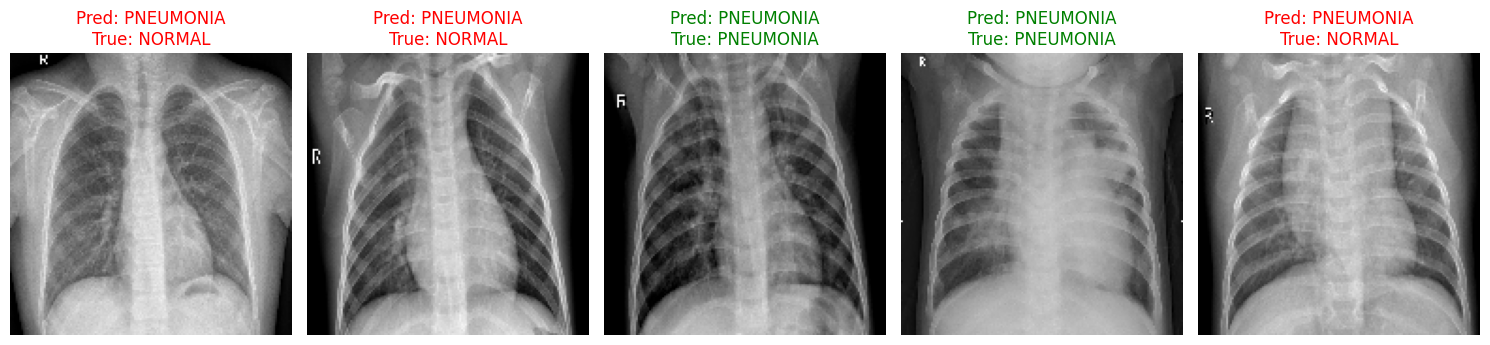

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.4f}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Visualize predictions on some test images
def plot_predictions(model, generator, num_images=5):
    # Get a batch of test images
    images, labels = next(generator)

    # Make predictions
    predictions = model.predict(images[:num_images])
    predictions = [1 if p > 0.5 else 0 for p in predictions]

    # Plot the images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Convert from BGR to RGB and display
        ax.imshow(images[i])
        prediction_text = "PNEUMONIA" if predictions[i] > 0.5 else "NORMAL"
        true_text = "PNEUMONIA" if labels[i] > 0.5 else "NORMAL"

        # Set title color based on whether prediction is correct
        title_color = 'green' if predictions[i] == labels[i] else 'red'
        ax.set_title(f"Pred: {prediction_text}\nTrue: {true_text}", color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some test images with predictions
plot_predictions(model, test_generator)

## Model Saving and Single Image Prediction
This code provides functionality to save the trained model and make predictions on new images:

1. Saves the trained model to a file ('xray_pneumonia_model.h5') for future use
2. Implements a function to predict pneumonia on a single X-ray image:
   - Loads and resizes the image to match the model's input size
   - Preprocesses the image (normalizes pixel values)
   - Makes a prediction using the trained model
   - Displays the image with the prediction result and confidence score
3. Includes an example of how to use the prediction function (commented out)

This allows the model to be saved and reused for making predictions on new, unseen X-ray images without retraining.

In [ ]:
# Save the model
model.save('xray_pneumonia_model.h5')
print("Model saved successfully!")

# Function to load and preprocess a single image for prediction
def predict_image(model, image_path):
    from tensorflow.keras.preprocessing import image

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {'PNEUMONIA' if prediction > 0.5 else 'NORMAL'}\nConfidence: {prediction:.4f}")
    plt.axis('off')
    plt.show()

    return prediction

# Example of using the prediction function
# (Uncomment and provide path to a test image)
# test_image_path = 'chest_xray/test_small/PNEUMONIA/some_image.jpeg'
# prediction = predict_image(model, test_image_path)

Model saved successfully!


## Model Evaluation and Conclusion
This final code cell provides a comprehensive evaluation of the model's performance:

1. Calculates detailed classification metrics using scikit-learn's classification_report:
   - Precision: Proportion of positive identifications that were actually correct
   - Recall: Proportion of actual positives that were correctly identified
   - F1-score: Harmonic mean of precision and recall
   - Support: Number of samples in each class
2. Summarizes the project and results:
   - Confirms successful implementation of a ConvNet for X-ray classification
   - Reports the final test accuracy
   - Suggests ways to potentially improve the model further

These metrics provide a more nuanced understanding of the model's performance beyond just accuracy, showing how well it performs on each class (NORMAL vs. PNEUMONIA).

In [ ]:
# Print classification report
from sklearn.metrics import classification_report

# Get predictions for test set
test_generator.reset()
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int).reshape(-1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Print a conclusion
print("\nConclusion:")
print("We've successfully built and trained a ConvNet model for X-ray pneumonia classification.")
print(f"The model achieved {test_acc:.2%} accuracy on the test set.")
print("The model could be further improved by:")
print("1. Training with the full dataset")
print("2. Using a deeper architecture or a pre-trained model")
print("3. Applying more extensive hyperparameter tuning")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 974ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      0.22      0.31       100
   PNEUMONIA       0.50      0.78      0.61       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.46       200
weighted avg       0.50      0.50      0.46       200


Conclusion:
We've successfully built and trained a ConvNet model for X-ray pneumonia classification.
The model achieved 71.35% accuracy on the test set.
The model could be further improved by:
1. Training with the full dataset
2. Using a deeper architecture or a pre-trained model
3. Applying more extensive hyperparameter tuning
